### Вступление

#### Цели данного ноутбука:
- Поучаствовать в [соревновании](https://www.kaggle.com/competitions/adengi-internship);
- Повторить методы ClassicML (4 месяца не решал классические задачки);
- Получить небольшой практический опыт, используя данные, приближенные к реальным(спасибо ребятам из А-деньги).

#### Description
В этом соревновании вам нужно будет натренировать модель оттока, которая лучше всех сможет генерализовать общую зависимость оттока.

#### Evaluation
Ответы модели будут оценены с помощью F1 метрики между предсказанными ответами и реальными.

#### Первые мысли
По сути стандартная задача бинарной классификаци.

Необходимо предсказать отток клиентов.

В зависимости от кол-ва данных, будем выбирать модель.

Предварительно, как многим известно, в подобных задачах себя очень хорошо зарекомендовали бустинги.
Я взглянул на файлик train.csv, он весит 2.2Гб, данных много, я думаю лучшим решением будут именно бустинги.

Но, т.к. я практикуюсь, мне не важно какой скор я выбью, лично мне важно попробовать разные подходы и поэкспериментировать.

Разумеется в рамках разумных сроков(решаю эту задачу только по выходным).

#### О данных
- monthly_income - среднемесячный заработок клиента (зарплата)
- payment_frequency - частота получения зарплаты (month - 1 раз в месяц, 2 weeks - раз в две недели, и тд)
- status - статус клиента (самозанятый, рабочий, и тд)
- work_experience - кол-во лет стажа клиента
- client_type - тип клиента (новый, повторный)
- settlement - город клиента
- requested_sum - запрашиваемая сумма клиента для займа, если interface - alfa
- region - регион клиента (область, округ, и тд)
- loan_id - уникальный идентификатор займа
- client_id - уникальный идентификатор клиента
- main_agreement_amount - основная одобренная сумма клиенту по займу (может быть больше, чем approved_amount)
- main_agreement_term - основной одобренный срок по займу
- requested_period_days - запрашиваемый срок по займу
- requested_amount - запрашиваемая сумма клиента по займу
- req_app_amount - разница между запрашиваемой суммой займа и одобренной
- approved_amount - одобренная сумма по займу
- source - канал привлечения клиента
- first_source - первый канал привлечения клиента
- period_days - период страховки по займу
- interface - интерфейс, откуда пришла заявка - (site, mobile)
- created_at - дата открытия займа
- type - тип займа (тип продукта)
- closed_at - дата закрытия займа
- days_finish_loan - время в днях, затраченное на закрытие займа (closed_at - created_at)
- gender - пол клиента
- ag - возраст клиента
- repayment_type - Тип комиссии по займу (с 2.5% - with_comission, 5% - with_big_comission, 0% - no_comission)
- loan_order - порядковый номер займа
- have_extension - имеется ли пролонгация по данному займу
- cnt_ext - кол-во пролонгаций по займу
- start_dt - дата начала (список) пролонгаций по займу
- term - срок пролонгации (список)
- price - цена пролонгации (список)
- elecs_sum - штрафы, пени
- recurents_sum - штрафы, пени (там вроде как различия в этапах их начисления)
- tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
- issues - сумма просрочек, штрафов и пени
- principal - сумма основного долга
- interest - прибыль с клиента
- overdue_interest - прибыль с клиента, если есть прослойка
- overdue_fee - штрафы в просрочек
- contact_cases - кол-во обращений клиента с коллекшн
- nbki_score - скор клиента от рисков

- churn - колонка таргета

### Imports

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from category_encoders.cat_boost import CatBoostEncoder

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight


from sklearn.metrics import accuracy_score, classification_report, f1_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import time
import warnings
from tqdm import tqdm

from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

### EDA

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

 уфффф....
данные прям подгружались несколько секунд, плотненько, в рамках обучения такого не было :D

Теперь. в общем то понятно. почему необходимо изучать Hadoop, Spark и т.д.

Оптимизирую данные

#### Оптимизация данных

In [15]:
def optimize_data(df):
    # оптимизируем числовые данные
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    # Оптимизируем даты
    df["created_at"] = pd.to_datetime(df["created_at"])
    df["start_dt"] = pd.to_datetime(df["start_dt"])

    return df

In [16]:
# Размер трейна до оптимизации
print(f"Размер датасета: {train.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета: 3231.96 MB


In [17]:
train = optimize_data(train)

In [18]:
# Размер трейна после оптимизации
print(f"Размер датасета: {train.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета: 2150.51 MB


In [8]:
# Размер теста до оптимизации
print(f"Размер датасета: {test.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета: 971.89 MB


In [13]:
test = optimize_data(test)

In [14]:
# Размер теста после оптимизации
print(f"Размер датасета: {test.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета: 619.54 MB


Не лучшая оптимизация, да, можно и эффективнее, но не в рамках данной задачи.

#### Продолжение EDA

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 45 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   monthly_income         float32       
 1   work_experience        float32       
 2   requested_sum          float32       
 3   main_agreement_amount  float32       
 4   main_agreement_term    float32       
 5   requested_period_days  float32       
 6   requested_amount       float32       
 7   req_app_amount         float32       
 8   approved_amount        float32       
 9   period_days            float32       
 10  days_finish_loan       float32       
 11  ag                     float32       
 12  cnt_ext                float32       
 13  term                   float32       
 14  price                  float32       
 15  elecs_sum              float32       
 16  recurents_sum          float32       
 17  tamount                float32       
 18  issues                

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   monthly_income         1348680 non-null  float32       
 1   work_experience        463225 non-null   float32       
 2   requested_sum          163790 non-null   float32       
 3   main_agreement_amount  1348743 non-null  float32       
 4   main_agreement_term    1348743 non-null  float32       
 5   requested_period_days  1200882 non-null  float32       
 6   requested_amount       1209772 non-null  float32       
 7   req_app_amount         1209772 non-null  float32       
 8   approved_amount        1348743 non-null  float32       
 9   period_days            1348743 non-null  float32       
 10  days_finish_loan       1348743 non-null  float32       
 11  ag                     1348743 non-null  float32       
 12  cnt_ext                15170

В тесте отсутствует фича:
- closed_at
Поэтому обрабатывать в трейне ее смысла нет, просто дропаем ее с двух ног

In [21]:
train.drop('closed_at', axis=1, inplace=True)

In [22]:
# посмотрю чутка на данные
pd.set_option('display.max_columns', None)
train[3036207:3036215]

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,payment_frequency,status,loan_id,client_id,source,first_source,interface,type,repayment_type,client_type,settlement,client_type.1,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn
3036207,-0.000749,-0.784665,NaN,1.703179,-0.398173,-0.479599,0.798492,-0.020140,1.253061,-0.398173,-0.521161,-1.450319,NaN,NaN,NaN,-0.063933,-0.143015,0.854447,-1.419908,1.419908,-0.452832,-0.218265,-0.185707,-1.497148,2,1,3923361,811926,11,0,0,2,1,1,г Корсаков,repeated,обл Сахалинская,female,10,0,NaN,2024-04-14 06:04:59,NaT,0
3036208,-0.000752,-1.653445,NaN,-0.761767,-0.340659,0.426103,-1.097625,-0.585785,-0.751240,-0.340659,1.693432,-1.450319,-0.011155,-0.25437,-0.786826,-0.063933,-0.143015,0.036902,0.663348,-0.663348,0.551209,1.521699,-0.185707,-1.393072,2,1,3371773,893529,11,5,2,2,0,1,деревня Пирогово,repeated,Респ Удмуртская,male,21,0,NaN,2024-02-10 19:01:25,NaT,0
3036209,-0.000752,-1.653445,NaN,-0.836463,0.176974,0.426103,-1.141721,-0.716318,-0.617620,0.176974,2.819184,-1.450319,NaN,NaN,NaN,-0.063933,-0.143015,-0.353018,0.726477,-0.726477,-0.277671,2.183983,3.156060,-1.393072,6,1,5230441,946363,11,11,0,2,1,1,г Октябрьский,repeated,Респ Башкортостан Башкортостан,male,4,0,NaN,2024-09-23 17:53:54,NaT,1
3036210,-0.000753,NaN,2.653853,-0.537681,-0.340659,NaN,NaN,NaN,-0.751240,-0.340659,6.399443,-1.138691,NaN,NaN,NaN,-0.063933,-0.143015,0.086805,0.473961,-0.473961,-0.240137,4.058721,-0.185707,0.081339,2,1,3937945,985493,11,0,2,2,1,1,село Наровчат,repeated,обл Пензенская,male,3,0,NaN,2024-04-15 18:14:06,NaT,0
3036211,-0.000747,0.952894,NaN,-0.089509,0.176974,-1.023020,-0.083423,0.153905,-0.350380,0.176974,-0.004422,0.003944,NaN,NaN,NaN,-0.063933,-0.143015,-0.083842,0.095187,-0.095187,0.077655,-0.218265,-0.185707,-0.074775,2,1,4137101,1067977,11,0,2,2,1,1,г Омск,repeated,обл Омская,male,3,0,NaN,2024-05-09 05:46:07,NaT,1
3036212,-0.000747,0.952894,NaN,0.059882,-0.570718,-1.204160,-0.083423,0.066883,-0.216760,-0.570718,-0.539616,0.003944,NaN,NaN,NaN,-0.063933,-0.143015,-0.155234,-0.031071,0.031071,-0.480357,-0.218265,-0.185707,-0.074775,2,1,2547947,130714,11,11,2,2,1,1,г Каменск-Уральский,repeated,обл Свердловская,female,13,0,NaN,2023-11-04 21:03:51,NaT,0
3036213,-0.000747,0.952894,NaN,0.059882,0.176974,-0.389028,-0.083423,0.066883,-0.216760,0.176974,-0.521161,0.003944,NaN,NaN,NaN,-0.063933,-0.143015,-0.155234,-0.031071,0.031071,-0.480357,-0.218265,-0.185707,-0.074775,2,1,2425702,168097,11,0,2,2,2,1,г Пенза,repeated,обл Пензенская,male,4,0,NaN,2023-10-22 13:53:21,NaT,0
3036214,-0.000751,-2.522225,NaN,-0.985853,-0.340659,0.426103,-0.788955,-0.020140,-1.152100,-0.340659,2.653090,-1.034815,NaN,NaN,NaN,-0.063933,-0.143015,-0.562457,0.852735,-0.852735,-0.397781,1.492742,2.178639,-1.367053,2,1,624133,271088,11,0,0,2,3,1,г Екатеринбург,repeated,обл Свердловская,female,4,0,NaN,2023-02-04 07:48:58,NaT,0


In [23]:
train.shape

(4036207, 44)

In [24]:
train.describe()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,payment_frequency,status,loan_id,client_id,source,first_source,interface,type,repayment_type,client_type,loan_order,have_extension,contact_cases,created_at,start_dt,churn
count,4.036000e+06,1.387847e+06,489817.000000,4.036207e+06,4.036207e+06,3.594589e+06,3.621371e+06,3.621371e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,453651.000000,453651.000000,453391.000000,4.030413e+06,4.030413e+06,4.034433e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,3.951731e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,225917.000000,4036207,454277,4.036207e+06
mean,-8.252137e-05,1.327218e-04,-0.000607,-1.432685e-04,1.383396e-04,3.266359e-04,-2.585168e-04,-3.262011e-04,7.910570e-05,1.383396e-04,1.463884e-04,7.153664e-05,0.000419,0.000688,0.001338,3.621228e-05,-1.119315e-05,1.909330e-04,1.432757e-05,-1.432757e-05,2.708035e-04,3.633105e-04,2.109298e-04,3.273373e-04,2.032218e+00,1.968183e+00,2.693898e+06,5.440669e+05,8.882859e+00,3.872205e+00,1.570352e+00,1.987750e+00,1.641676e+00,7.609392e-01,5.557003e+00,1.125505e-01,1.506301,2023-11-06 06:21:45.347923456,2023-11-17 00:42:24.480867072,2.938724e-01
min,-7.560081e-04,-2.522225e+00,-0.592014,-9.858535e-01,-1.145865e+00,-1.657011e+00,-1.318104e+00,-5.241477e+00,-1.152100e+00,-1.145865e+00,-5.396155e-01,-1.761946e+00,-0.720608,-1.149255,-0.908121,-6.393252e-02,-1.430153e-01,-9.813316e-01,-2.530520e+02,-1.105251e+00,-5.028780e-01,-2.182650e-01,-1.857070e-01,-1.766011e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000,2022-04-19 06:50:05,2022-04-28 21:26:55,0.000000e+00
25%,-7.505928e-04,-7.846653e-01,-0.462179,-6.870721e-01,-3.406587e-01,-3.890285e-01,-8.330510e-01,-6.292958e-01,-7.512400e-01,-3.406587e-01,-4.104309e-01,-8.270634e-01,-0.720608,-0.561187,-0.647906,-6.393252e-02,-1.430153e-01,-5.762984e-01,-4.098445e-01,-6.002190e-01,-4.778550e-01,-2.182650e-01,-1.857070e-01,-8.119808e-01,2.000000e+00,1.000000e+00,1.348026e+06,2.463075e+05,1.100000e+01,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,1.000000,2023-06-03 18:37:20,2023-06-25 21:29:29,0.000000e+00
50%,-7.488827e-04,8.411442e-02,-0.267427,-3.209154e-01,1.769741e-01,4.261034e-01,-8.342338e-02,-1.071620e-01,-2.167598e-01,1.769741e-01,-2.443364e-01,-9.993219e-02,-0.720608,-0.561187,-0.343282,-6.393252e-02,-1.430153e-01,-2.610464e-01,2.845741e-01,-2.845741e-01,-3.152056e-01,-2.182650e-01,-1.857070e-01,-1.788514e-01,2.000000e+00,1.000000e+00,2.695315e+06,5.102150e+05,1.100000e+01,0.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,1.000000,2023-11-22 08:52:46,2023-12-11 09:15:12,0.000000e+00
75%,-7.448212e-04,9.528942e-01,0.057159,5.080537e-01,1.769741e-01,4.261034e-01,1.195353e+00,6.760386e-01,5.181504e-01,1.769741e-01,-4.422167e-03,6.271990e-01,0.698299,0.256993,0.260883,-6.393252e-02,-1.430153e-01,2.935129e-01,6.002190e-01,4.098445e-01,5.763692e-02,-2.182650e-01,-1.857070e-01,7.448238e-01,2.000000e+00,1.000000e+00,4.039128e+06,8.165970e+05,1.100000e+01,1.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,7.000000e+00,0.000000e+00,1.000000,2024-04-27 15:37:10.500000,2024-04-25 05:45:35,1.000000e+00
max,1.339736e+03,9.528942e-01,5.899720,1.141358e+01,8.804188e+00,1.401163e+01,7.412853e+00,5.636309e+00,9.938363e+00,8.804188e+00,1.651275e+01,4.470607e+00,3.536112,3.274034,10.166474,9.001068e+01,6.804536e+01,2.821236e+02,1.105251e+00,2.530520e+02,6.156176e+01,1.460302e+02,4.719982e+01,2.535800e+00,7.0

#### База
- База:
    - проверка на дубликаты;
    - обработка пропусков;
    - грамотная обработка категориальных переменных;
    - кодирование категориальных переменных;
    - знакомство с балансом целевой переменной;

##### Проверка на дубликаты

In [25]:
# проверим на пропуски, повторы и т.д.
print(f'Количество дубликатов: {train.duplicated().sum()}')

Количество дубликатов: 0


Хороший дубликат - отсутствующий дубликат

##### Проверка на пропуски

In [26]:
# количество пропущенных значений по фичам:
train.isnull().sum()/len(train)*100

monthly_income            0.005129
work_experience          65.615069
requested_sum            87.864423
main_agreement_amount     0.000000
main_agreement_term       0.000000
requested_period_days    10.941411
requested_amount         10.277867
req_app_amount           10.277867
approved_amount           0.000000
period_days               0.000000
days_finish_loan          0.000000
ag                        0.000000
cnt_ext                  88.760462
term                     88.760462
price                    88.766904
elecs_sum                 0.143551
recurents_sum             0.143551
tamount                   0.043952
issues                    0.000000
principal                 0.000000
interest                  0.000000
overdue_interest          0.000000
overdue_fee               0.000000
nbki_score                2.092955
payment_frequency         0.000000
status                    0.000000
loan_id                   0.000000
client_id                 0.000000
source              

Отличились следующие фичи:
- work_experience - стаж - 65% пропусков
- requested_sum - запрашиваемая сумма клиента для займа - 88% пропусков
- cnt_ext - кол-во пролонгаций по займу - 89% пропусков
- term - срок пролонгации (список) - 89% пропусков
- price -  цена пролонгации (список) - 89% пропусков
- contact_cases - кол-во обращений клиента с коллекшн - 94% пропусков
- start_dt  -  дата начала (список) пролонгаций по займу - 89% пропусков

##### Обработка пропусков
Фичи, в которых больше 65% пропусков я думаю, не имеет особого смысла подавать в модель.
Лучше от них избавиться.

Там где % пропусков существенно ниже, будем заменять средними значениями.(Да, конечно можно медианой, наиболее часто встречающимися и т.д., но это уже не в рамках учебного датасетика)

In [27]:
# список столбцов для удаления
col_to_drop = ['work_experience', 'requested_sum', 'cnt_ext', 'term', 'price', 'contact_cases', 'start_dt']
# список столбцов для заполнения
col_to_change = ['monthly_income','requested_period_days','requested_amount','req_app_amount','elecs_sum',
                 'recurents_sum','tamount','nbki_score']

In [28]:
# удаляем столбцы
train.drop(axis=1, labels=col_to_drop, inplace=True)
test.drop(axis=1, labels=col_to_drop, inplace=True)

In [29]:
# заполняем все пропущенные значения средними, сгруппировав колонки по городу
# для трейна
train[col_to_change] = train.groupby('settlement')[col_to_change].transform(lambda x: x.fillna(x.mean()))
# для теста
test[col_to_change] = test.groupby('settlement')[col_to_change].transform(lambda x: x.fillna(x.mean()))

In [30]:
# Заполняем остатки
# трейн
train[col_to_change] = train[col_to_change].fillna(train[col_to_change].mean())
# тест
test[col_to_change] = test[col_to_change].fillna(train[col_to_change].mean())

In [31]:
# количество пропущенных значений по фичамв трейне:
train.isnull().sum()/len(train)*100

monthly_income           0.0
main_agreement_amount    0.0
main_agreement_term      0.0
requested_period_days    0.0
requested_amount         0.0
req_app_amount           0.0
approved_amount          0.0
period_days              0.0
days_finish_loan         0.0
ag                       0.0
elecs_sum                0.0
recurents_sum            0.0
tamount                  0.0
issues                   0.0
principal                0.0
interest                 0.0
overdue_interest         0.0
overdue_fee              0.0
nbki_score               0.0
payment_frequency        0.0
status                   0.0
loan_id                  0.0
client_id                0.0
source                   0.0
first_source             0.0
interface                0.0
type                     0.0
repayment_type           0.0
client_type              0.0
settlement               0.0
client_type.1            0.0
region                   0.0
gender                   0.0
loan_order               0.0
have_extension

In [32]:
# количество пропущенных значений по фичамв тесте:
test.isnull().sum()/len(test)*100

monthly_income           0.0
main_agreement_amount    0.0
main_agreement_term      0.0
requested_period_days    0.0
requested_amount         0.0
req_app_amount           0.0
approved_amount          0.0
period_days              0.0
days_finish_loan         0.0
ag                       0.0
elecs_sum                0.0
recurents_sum            0.0
tamount                  0.0
issues                   0.0
principal                0.0
interest                 0.0
overdue_interest         0.0
overdue_fee              0.0
nbki_score               0.0
payment_frequency        0.0
status                   0.0
loan_id                  0.0
client_id                0.0
source                   0.0
first_source             0.0
interface                0.0
type                     0.0
repayment_type           0.0
client_type              0.0
settlement               0.0
client_type.1            0.0
region                   0.0
gender                   0.0
loan_order               0.0
have_extension

##### Грамотная обработка категориальных переменных

Список категориальныъх признаков:

- settlement - город клиента
- client_type.1 - тип клиента (новый, повторный)
- region - регион клиента (область, округ, и тд)
- gender - пол
- created_at - дата открытия займа
- closed_at - дата закрытия займа

Первое, что приходит в голову - город и регион будут кореллировать между собой, поэтому от региона, я бы избавился 100%

Остальные колонки надо рассматривать более подробно

In [33]:
cat_cols = ['settlement','client_type.1','region','gender','created_at']

In [34]:
train[cat_cols]

,settlement,client_type.1,region,gender,created_at
0,г Москва,repeated,г Москва,male,2022-12-23 17:50:25
1,г Москва,repeated,г Москва,female,2024-06-29 22:26:08
2,г Пермь,repeated,край Пермский,male,2023-04-10 21:06:38
3,г Самара,repeated,обл Самарская,female,2023-10-01 00:13:16
4,г Москва,repeated,г Москва,female,2024-07-15 10:40:35
...,...,...,...,...,...
4036202,г Ногинск,repeated,обл Московская,female,2023-05-03 13:08:33
4036203,г Данилов,repeated,обл Ярославская,female,2023-09-13 17:52:03
4036204,г Санкт-Петербург,repeated,г Санкт-Петербург,male,2023-12-13 20:56:45
4036205,г Нижний Ломов,repeated,обл Пензенская,male,2024-08-27 23:36:06


###### Бинарные признаки

In [35]:
# удаляем регион
# для трейна
train.drop(columns=['region'], inplace=True)
# для теста
test.drop(columns=['region'], inplace=True)

In [36]:
# кодируем бинарные признаки для трейна
label_enc_cols = ['client_type.1', 'gender']
for col in label_enc_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

In [37]:
# кодируем бинарные признаки для теста
label_enc_cols = ['client_type.1', 'gender']
for col in label_enc_cols:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])

###### Кодирование городов клиентов

Города сильно различаются, поэтому **One-Hot Encoding не подойдёт** (слишком много новых фич).

CatBoost Encoding (учитывает вероятности, полезно для ML-моделей).

In [38]:
cat_enc = CatBoostEncoder()
train['settlement'] = cat_enc.fit_transform(train['settlement'], train['churn'])

In [39]:
# Применяем обученный энкодер к test (без .fit!)
test['settlement'] = cat_enc.transform(test['settlement'])

In [40]:
# проверка на случай пропусков (если вдруг в тесте были новые города)
test['settlement'].isna().sum()

0

###### Работа с датами

Даты нельзя просто так закодировать.

От них нужно или отказаться или же выделить полезные числовые признаки.

Получим новые признаки, а исходные столбцы удалим

In [41]:
# для трейна
train['created_at'] = pd.to_datetime(train['created_at'])

# День, месяц, год, день недели
train['created_day'] = train['created_at'].dt.day
train['created_month'] = train['created_at'].dt.month
train['created_weekday'] = train['created_at'].dt.weekday  # 0 = Понедельник, 6 = Воскресенье

# Удаление изначальных столбцов
train.drop(columns=['created_at'], inplace=True)

In [42]:
# для теста
test['created_at'] = pd.to_datetime(test['created_at'])

# День, месяц, год, день недели
test['created_day'] = test['created_at'].dt.day
test['created_month'] = test['created_at'].dt.month
test['created_weekday'] = test['created_at'].dt.weekday  # 0 = Понедельник, 6 = Воскресенье

# Удаление изначальных столбцов
test.drop(columns=['created_at'], inplace=True)

In [43]:
# взглянем на обновленные категориальные фичи!
cat_cols = ['settlement','client_type.1','gender', 'created_day','created_month','created_weekday']
train[cat_cols]

,settlement,client_type.1,gender,created_day,created_month,created_weekday
0,0.293872,1,1,23,12,4
1,0.146936,1,0,29,6,5
2,0.293872,1,1,10,4,0
3,0.293872,1,0,1,10,6
4,0.097957,1,0,15,7,0
...,...,...,...,...,...,...
4036202,0.256162,1,0,3,5,2
4036203,0.263662,1,0,13,9,2
4036204,0.287153,1,1,13,12,2
4036205,0.275080,1,1,27,8,1


##### Баланс классов

In [44]:
# посмотрим на баланс классов
train['churn'].value_counts()

churn
0    2850077
1    1186130
Name: count, dtype: int64

Перекос безусловно присутствует, но не настолько критичный.
ИМХО(данных достаточно, чтобы дропнуть 0 таргеты и выровнять из с 1, но я решил немножко сделать иначе.

Для класса 0:

    - Уменьшу кол-во на (2850077-1186130)//2 = 831973

Для класса 1:

    - Создам синтетические данные, увеличу на (2850077-1186130)//2 + 1 = 831974

Итого будет:

    - 0 2018104
    
    - 1 2018104


Вообще говоря, для 0 можно использовать Cluster-based undersampling, вместо случайного удаления наблюдений, можно кластеризовать и удалять наиболее похожие, но я не буду на это терять время.

In [58]:
# Разделяем классы
churn_0 = train[train['churn'] == 0]
churn_1 = train[train['churn'] == 1]

In [59]:
# **Undersampling:** случайно удаляем 831973 записей класса 0
churn_0_sampled = churn_0.sample(n=len(churn_0) - 831973, random_state=42)

In [60]:
# Объединяем обе выборки перед SMOTE
train_balancing = pd.concat([churn_0_sampled, churn_1], axis=0)

In [61]:
# **Oversampling:** добавляем 831974 записей класса 1 с помощью SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy=1.0, random_state=42).fit_resample(
    train_balancing.drop(columns=['churn']), train_balancing['churn'])

In [62]:
# Превращаем в датафрейм
balanced_train = pd.DataFrame(X_resampled, columns=train_balancing.drop(columns=['churn']).columns)
balanced_train['churn'] = y_resampled

In [64]:
# Проверяем баланс
print(balanced_train['churn'].value_counts())

churn
0    2018104
1    2018104
Name: count, dtype: int64


Прекрасно!
Двигаемся дальше!)

#### Feature Engineering

- Feature engineering:
    - корреляции;
    - нормирование данных;
    - снижение размерности.

##### Корреляции

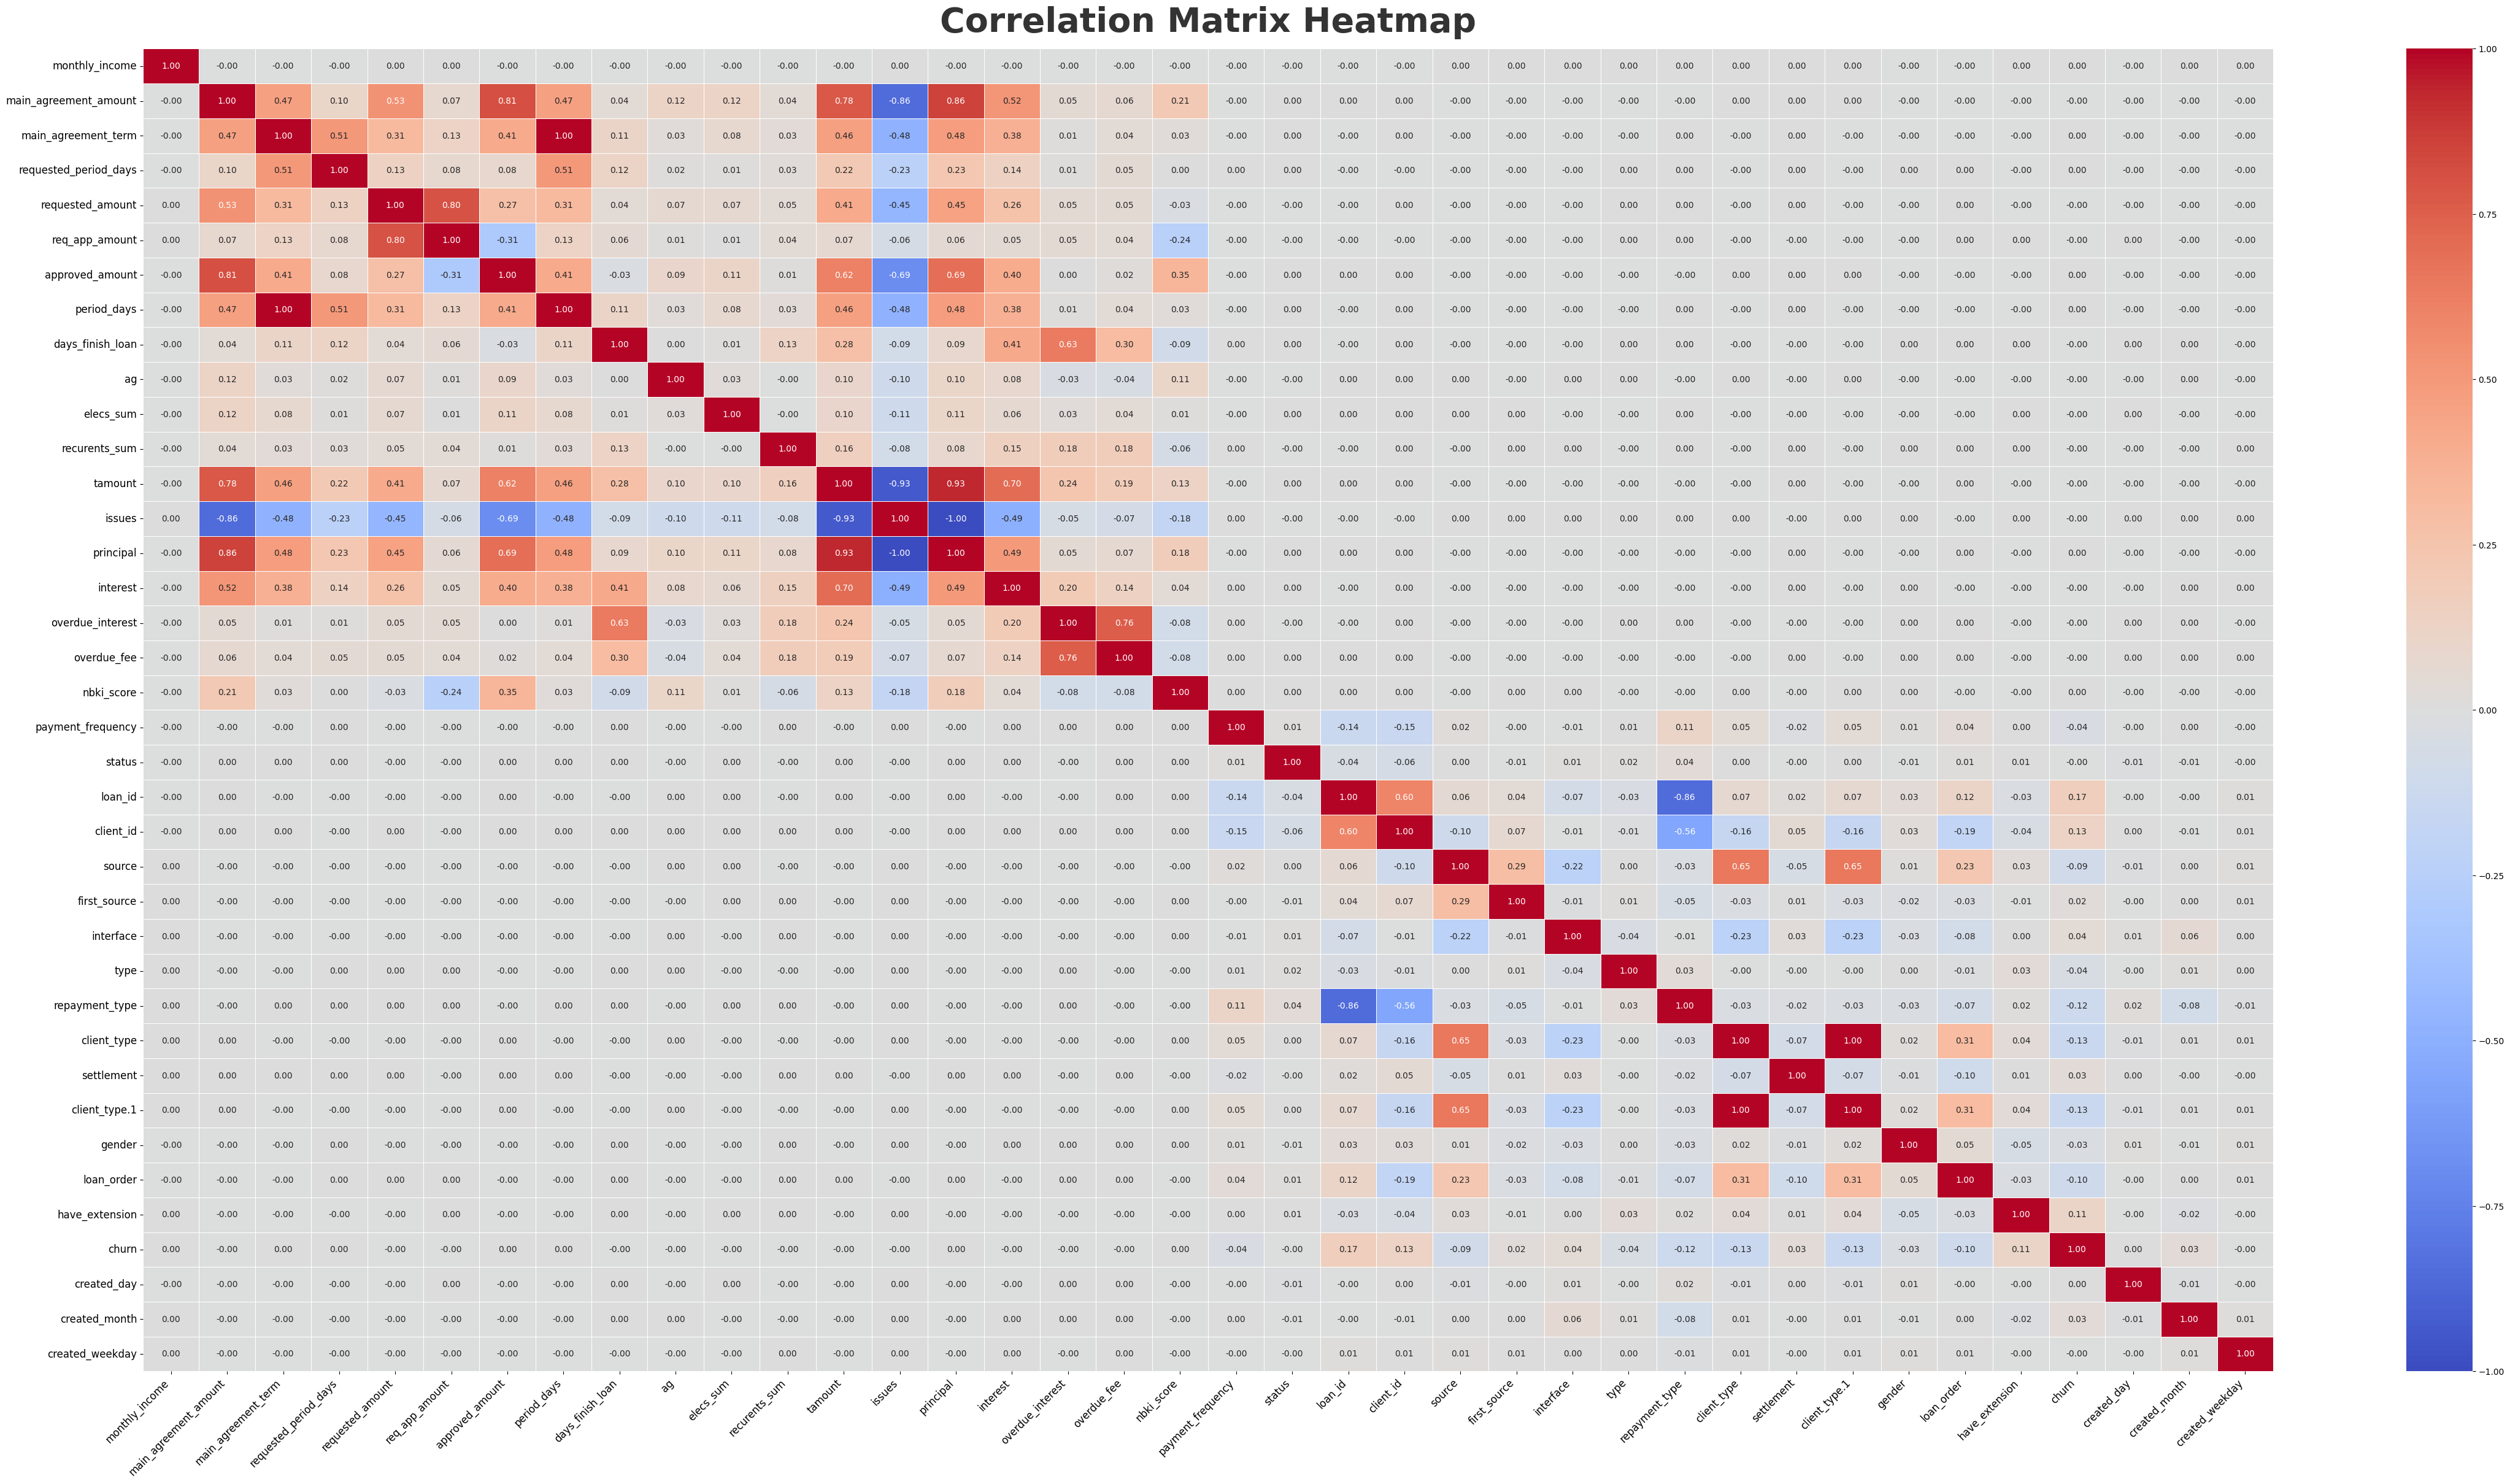

In [67]:
# создаем матрицу корреляций
correlation_matrix = train.corr()
# Создаём heatmap
plt.figure(figsize=(56, 28))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor="white"
)

# Настройки осей
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

# Заголовок
plt.title("Correlation Matrix Heatmap", fontsize=40, weight='bold', color="#333333", pad=20)

# **Сохраняем картинку**
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")  # 300 DPI для качества

# Показываем график
plt.show()

Рассмотрев детальнее матрицу корреляций можно видеть:
- Отрицательные корреляции < -0.9:
  - issues - сумма просрочек, штрафов и пени и tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
  - issues - сумма просрочек, штрафов и пени и tamount и principal - сумма основного долга и 
- Положительные корреляции > 0.9:
  - period_days - период страховки по займу и main_agreement_term - основной одобренный срок по займу
  - principal - сумма основного долга и tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
  - client_type и client_type.1 - видать просто задвоили столбцы

Считаю, что необходимо избавиться от: ['period_days','principal','tamount', 'client_type.1']

In [68]:
# да, просто так кодировал признак собсна)))
sum(train['client_type'] == train['client_type.1'])

4036207

In [69]:
# Дропаем сильнокоррелирующие между собой столбцы
# трейн
train.drop(axis=1, labels=['period_days','principal','tamount', 'client_type.1'], inplace=True)
# тест
test.drop(axis=1, labels=['period_days','principal','tamount', 'client_type.1'], inplace=True)

##### Нормирование данных

Т.к. наши данные в различных единицах измерения, хорошо бы их привести к общей шкале измерений.
Но, поскольку мы будем пользоваться Бустингами, то нет необходимости это делать. Скипнем данный шаг.

##### Снижение размерностей

Данный шаг так же пока что пропущу, т.к. буду пробовать изначально бустинг)

### DataPreparating

Основная часть EDA была завершена, теперь необходимо:
- Подготовить данные;
- Приступить к обучению модели бустинга.

In [70]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 33 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   monthly_income         1348743 non-null  float32
 1   main_agreement_amount  1348743 non-null  float32
 2   main_agreement_term    1348743 non-null  float32
 3   requested_period_days  1348743 non-null  float32
 4   requested_amount       1348743 non-null  float32
 5   req_app_amount         1348743 non-null  float32
 6   approved_amount        1348743 non-null  float32
 7   days_finish_loan       1348743 non-null  float32
 8   ag                     1348743 non-null  float32
 9   elecs_sum              1348743 non-null  float32
 10  recurents_sum          1348743 non-null  float32
 11  issues                 1348743 non-null  float32
 12  interest               1348743 non-null  float32
 13  overdue_interest       1348743 non-null  float32
 14  overdue_fee       

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 34 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   monthly_income         float32
 1   main_agreement_amount  float32
 2   main_agreement_term    float32
 3   requested_period_days  float32
 4   requested_amount       float32
 5   req_app_amount         float32
 6   approved_amount        float32
 7   days_finish_loan       float32
 8   ag                     float32
 9   elecs_sum              float32
 10  recurents_sum          float32
 11  issues                 float32
 12  interest               float32
 13  overdue_interest       float32
 14  overdue_fee            float32
 15  nbki_score             float32
 16  payment_frequency      int8   
 17  status                 int8   
 18  loan_id                int32  
 19  client_id              int32  
 20  source                 int8   
 21  first_source           int8   
 22  interface         

### TrainModel

In [72]:
X = train.drop(['churn'], axis=1)
y = train['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# эту функцию я честно украл у https://www.kaggle.com/code/korcy78/baseline
def train_and_predict(model, X_train, X_test, y_train, y_test):

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test and train data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Train and test F1 scores
    f1_train = round(f1_score(y_train, y_pred_train, average="weighted") * 100, 3)
    f1_test = round(f1_score(y_test, y_pred_test, average="weighted") * 100, 3)
    print(f"\nTrain and Test F1 Scores:")
    print(f"\t>> Train F1 Score: {f1_train}%")
    print(f"\t>> Test F1 Score: {f1_test}%")

    # Classification Report
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_pred_test))

    report = classification_report(y_test, y_pred_test, output_dict=True)

In [76]:
# CatBoost
cb_model = CatBoostClassifier(random_state=42, verbose=0, iterations=100)
train_and_predict(cb_model, X_train, X_test, y_train, y_test)


Train and Test F1 Scores:
	>> Train F1 Score: 68.565%
	>> Test F1 Score: 68.524%

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.74      0.95      0.84    569988
           1       0.66      0.21      0.32    237254

    accuracy                           0.74    807242
   macro avg       0.70      0.58      0.58    807242
weighted avg       0.72      0.74      0.69    807242



In [77]:
# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
train_and_predict(xgb_model, X_train, X_test, y_train, y_test)


Train and Test F1 Scores:
	>> Train F1 Score: 68.737%
	>> Test F1 Score: 68.572%

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.74      0.95      0.84    569988
           1       0.65      0.22      0.32    237254

    accuracy                           0.74    807242
   macro avg       0.70      0.58      0.58    807242
weighted avg       0.72      0.74      0.69    807242



In [78]:
# LightGBM
lgb_model = LGBMClassifier(random_state=42,verbose=-1)
train_and_predict(lgb_model, X_train, X_test, y_train, y_test)


Train and Test F1 Scores:
	>> Train F1 Score: 68.548%
	>> Test F1 Score: 68.53%

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.74      0.95      0.84    569988
           1       0.66      0.21      0.32    237254

    accuracy                           0.74    807242
   macro avg       0.70      0.58      0.58    807242
weighted avg       0.72      0.74      0.69    807242



#### Оценка важности фичей

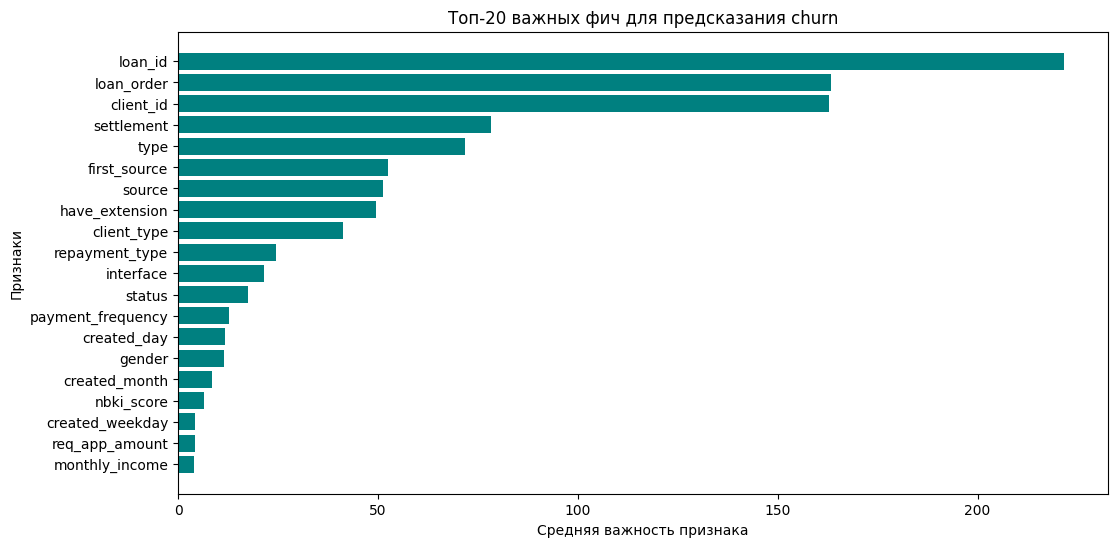

           Feature  LGBM   XGBoost   CatBoost  Mean_Importance
18         loan_id   634  0.113672  30.527979       221.547217
28      loan_order   458  0.082014  31.734363       163.272126
19       client_id   484  0.010074   4.638219       162.882764
26      settlement   232  0.005718   2.572780        78.192833
23            type   208  0.123978   7.423382        71.849120
21    first_source   156  0.012577   1.909130        52.640569
20          source   152  0.012108   1.578249        51.196786
29  have_extension   134  0.359331  13.983117        49.447483
25     client_type   123  0.164465   0.770412        41.311626
24  repayment_type    73  0.007239   0.617355        24.541531


In [84]:
# Получаем важность фич для каждой модели
lgbm_importance = lgb_model.feature_importances_
xgb_importance = xgb_model.feature_importances_
cat_importance = cb_model.get_feature_importance()

# Приводим к DataFrame
features = train.drop(columns=['churn']).columns
df_importance = pd.DataFrame({
    'Feature': features,
    'LGBM': lgbm_importance,
    'XGBoost': xgb_importance,
    'CatBoost': cat_importance
})

# Усредняем важность фич
df_importance['Mean_Importance'] = df_importance[['LGBM', 'XGBoost', 'CatBoost']].mean(axis=1)

# Сортируем по средней важности
df_importance = df_importance.sort_values(by='Mean_Importance', ascending=False)

# Визуализируем топ-20 фич
plt.figure(figsize=(12, 6))
plt.barh(df_importance['Feature'][:20], df_importance['Mean_Importance'][:20], color='teal')
plt.gca().invert_yaxis()
plt.xlabel('Средняя важность признака')
plt.ylabel('Признаки')
plt.title('Топ-20 важных фич для предсказания churn')
plt.show()

# Вывод первых 10 фич
print(df_importance.head(10))


In [89]:
# Определим порог важности (например, 0.01 — 1% влияния)
threshold = 0.01

# Оставляем только важные фичи
important_features = df_importance[df_importance['Mean_Importance'] > threshold]['Feature'].values

# Обновляем train и test
train_filtered = train[important_features]
test_filtered = test[important_features]

In [90]:
X = train_filtered
y = train['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# CatBoost
cb_model = CatBoostClassifier(random_state=42, verbose=0, iterations=100, auto_class_weights="Balanced")
train_and_predict(cb_model, X_train, X_test, y_train, y_test)


Train and Test F1 Scores:
	>> Train F1 Score: 66.553%
	>> Test F1 Score: 66.468%

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.81      0.66      0.73    569988
           1       0.43      0.62      0.51    237254

    accuracy                           0.65    807242
   macro avg       0.62      0.64      0.62    807242
weighted avg       0.70      0.65      0.66    807242



In [100]:
# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=2.4)
train_and_predict(xgb_model, X_train, X_test, y_train, y_test)


Train and Test F1 Scores:
	>> Train F1 Score: 66.82%
	>> Test F1 Score: 66.523%

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.81      0.67      0.73    569988
           1       0.43      0.62      0.51    237254

    accuracy                           0.65    807242
   macro avg       0.62      0.64      0.62    807242
weighted avg       0.70      0.65      0.67    807242



In [109]:
# LightGBM
lgb_model = LGBMClassifier(random_state=42,verbose=-1, class_weight={0: 1, 1: 2.4})
train_and_predict(lgb_model, X_train, X_test, y_train, y_test)


Train and Test F1 Scores:
	>> Train F1 Score: 66.428%
	>> Test F1 Score: 66.376%

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.81      0.66      0.73    569988
           1       0.43      0.62      0.51    237254

    accuracy                           0.65    807242
   macro avg       0.62      0.64      0.62    807242
weighted avg       0.70      0.65      0.66    807242



### Results

In [103]:
# выбираем лучшую модельку
models = {"XGBoost": xgb_model, "LightGBM": lgb_model, "CatBoost": cb_model}
best_model_name, best_model = max(models.items(), key=lambda x: f1_score(y_test, x[1].predict(X_test)))

In [104]:
print(f"\n🏆 Лучшая модель: {best_model_name}")


🏆 Лучшая модель: CatBoost


In [105]:
# === Предсказания на test.csv ===
test_preds = best_model.predict(test_filtered)

In [106]:
# === Готовим submission для Kaggle ===
submission = pd.DataFrame({'loan_id': test['loan_id'], 'churn': test_preds})
submission.to_csv('submission2.csv', index=False)

print("\n✅ Файл submission.csv готов! 🎯")


✅ Файл submission.csv готов! 🎯


На сегодня пока что все. Надо сабмитнуть, посмотреть на каком я там месте.

Наверняка в топах с конца!)

Обвноеление комментария.

В общем то, какого то сверхестественного результата получить не удалось.

Необходимо дальше изучать способы обработки данных для обучения моделей.

Score выбил всего лишь 0.45, но радует, что я не один такой:D

Я думаю, копать необходимо в следующих направлениях:

- Лучшее изучение бустингов;
- Глубокое изучение обработки данных (даже балансировка классов не дала хорошего профита);
- Прорабатывать понимание метрик и интерпретацию результатов;
- Искать опыт в ноутбуках подобных задач на kaggle;
- Изучать литуретару;
- Практиковаться